# Практическое задание №7 по теме "Рекурентные сети для обработки последовательностей".

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from tqdm import tqdm 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
torch.manual_seed(42)

### Загрузка данных

In [3]:
df = pd.read_csv("data/Twitter_Sentiment_Analysis/train.csv")

Так как в файле test.csv отсутствует целевой признак для валидации, возьмем файл train.csv и разделим его на тренировочную и валидационную выборки:

In [4]:
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)

In [5]:
train_df.head()

,id,label,tweet
12110,12111,1,@user @user @user because i've been paying att...
14081,14082,0,@user raft building at salford quays as pa of...
1829,1830,0,friday ð ð» #gdegblog #friday #selfie #b...
2769,2770,0,#fashion it is a true #fact
31818,31819,0,"so to #share the #simple, #elegant #business..."


In [6]:
val_df.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


Присутствует дисбаланс классов:

In [7]:
train_df['label'].value_counts()

0    23783
1     1786
Name: label, dtype: int64

In [8]:
val_df['label'].value_counts()

0    5937
1     456
Name: label, dtype: int64

### Обработка

In [9]:
max_words = 2000
max_len = 20
num_classes = 1

In [10]:
sw = set(get_stop_words("en"))

In [11]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [12]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [13]:
tqdm.pandas()

train_df['tweet'] = train_df['tweet'].progress_apply(preprocess_text)
val_df['tweet'] = val_df['tweet'].progress_apply(preprocess_text)

100%|████████████████████████████████████████████████████████████████████████████| 6393/6393 [00:01<00:00, 6276.63it/s]


In [14]:
train_corpus = " ".join(train_df["tweet"])
train_corpus = train_corpus.lower()

In [15]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


['user', 'user', 'user', 'ive', 'paying']

In [16]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [17]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [18]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'im', 'u', 'life']

In [19]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [20]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [21]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in train_df["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in val_df["tweet"]])

CPU times: total: 2.31 s
Wall time: 2.32 s


### Построение сети и обучение

In [22]:
batch_size = 512
print_batch_n = 100

In [23]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [24]:
train_dataset = DataWrapper(x_train, train_df['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, val_df['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

#### Создадим и обучим сеть LSTM

In [25]:
epochs = 10

In [26]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [27]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [28]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 271381


In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [30]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history_LSTM = []
test_loss_history_LSTM = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history_LSTM.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history_LSTM.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [50/50]. Loss: 0.387. Acc: 0.737. Test loss: 0.347. Test acc: 0.929
Epoch [2/10]. Step [50/50]. Loss: 0.274. Acc: 0.930. Test loss: 0.069. Test acc: 0.929
Epoch [3/10]. Step [50/50]. Loss: 0.242. Acc: 0.930. Test loss: 0.069. Test acc: 0.929
Epoch [4/10]. Step [50/50]. Loss: 0.205. Acc: 0.932. Test loss: 0.059. Test acc: 0.941
Epoch [5/10]. Step [50/50]. Loss: 0.164. Acc: 0.944. Test loss: 0.027. Test acc: 0.943
Epoch [6/10]. Step [50/50]. Loss: 0.167. Acc: 0.948. Test loss: 0.018. Test acc: 0.947
Epoch [7/10]. Step [50/50]. Loss: 0.144. Acc: 0.951. Test loss: 0.016. Test acc: 0.948
Epoch [8/10]. Step [50/50]. Loss: 0.128. Acc: 0.955. Test loss: 0.010. Test acc: 0.948
Epoch [9/10]. Step [50/50]. Loss: 0.114. Acc: 0.957. Test loss: 0.007. Test acc: 0.948
Epoch [10/10]. Step [50/50]. Loss: 0.121. Acc: 0.958. Test loss: 0.011. Test acc: 0.948
Training is finished!


In [31]:
t_l_LSTM = test_loss_history_LSTM[epochs-1]
t_acc_LSTM = ((test_running_right / test_running_total).cpu()).numpy()

#### Создадим и обучим GRU

In [32]:
epochs = 15

In [33]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [34]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [35]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 267541


In [36]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history_GRU = []
test_loss_history_GRU = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history_GRU.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history_GRU.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/15]. Step [50/50]. Loss: 0.291. Acc: 0.674. Test loss: 0.180. Test acc: 0.929
Epoch [2/15]. Step [50/50]. Loss: 0.269. Acc: 0.930. Test loss: 0.069. Test acc: 0.929
Epoch [3/15]. Step [50/50]. Loss: 0.252. Acc: 0.930. Test loss: 1.310. Test acc: 0.931
Epoch [4/15]. Step [50/50]. Loss: 0.209. Acc: 0.937. Test loss: 0.061. Test acc: 0.942
Epoch [5/15]. Step [50/50]. Loss: 0.182. Acc: 0.946. Test loss: 0.033. Test acc: 0.946
Epoch [6/15]. Step [50/50]. Loss: 0.162. Acc: 0.949. Test loss: 2.822. Test acc: 0.946
Epoch [7/15]. Step [50/50]. Loss: 0.097. Acc: 0.953. Test loss: 0.016. Test acc: 0.948
Epoch [8/15]. Step [50/50]. Loss: 0.114. Acc: 0.957. Test loss: 0.016. Test acc: 0.948
Epoch [9/15]. Step [50/50]. Loss: 0.090. Acc: 0.957. Test loss: 1.004. Test acc: 0.947
Epoch [10/15]. Step [50/50]. Loss: 0.123. Acc: 0.960. Test loss: 0.009. Test acc: 0.947
Epoch [11/15]. Step [50/50]. Loss: 0.138. Acc: 0.962. Test loss: 0.032. Test acc: 0.950
Epoch [12/15]. Step [50/50]. Loss: 0.123.

In [37]:
t_l_GRU = test_loss_history_GRU[epochs-1]
t_acc_GRU = ((test_running_right / test_running_total).cpu()).numpy()

#### Результаты

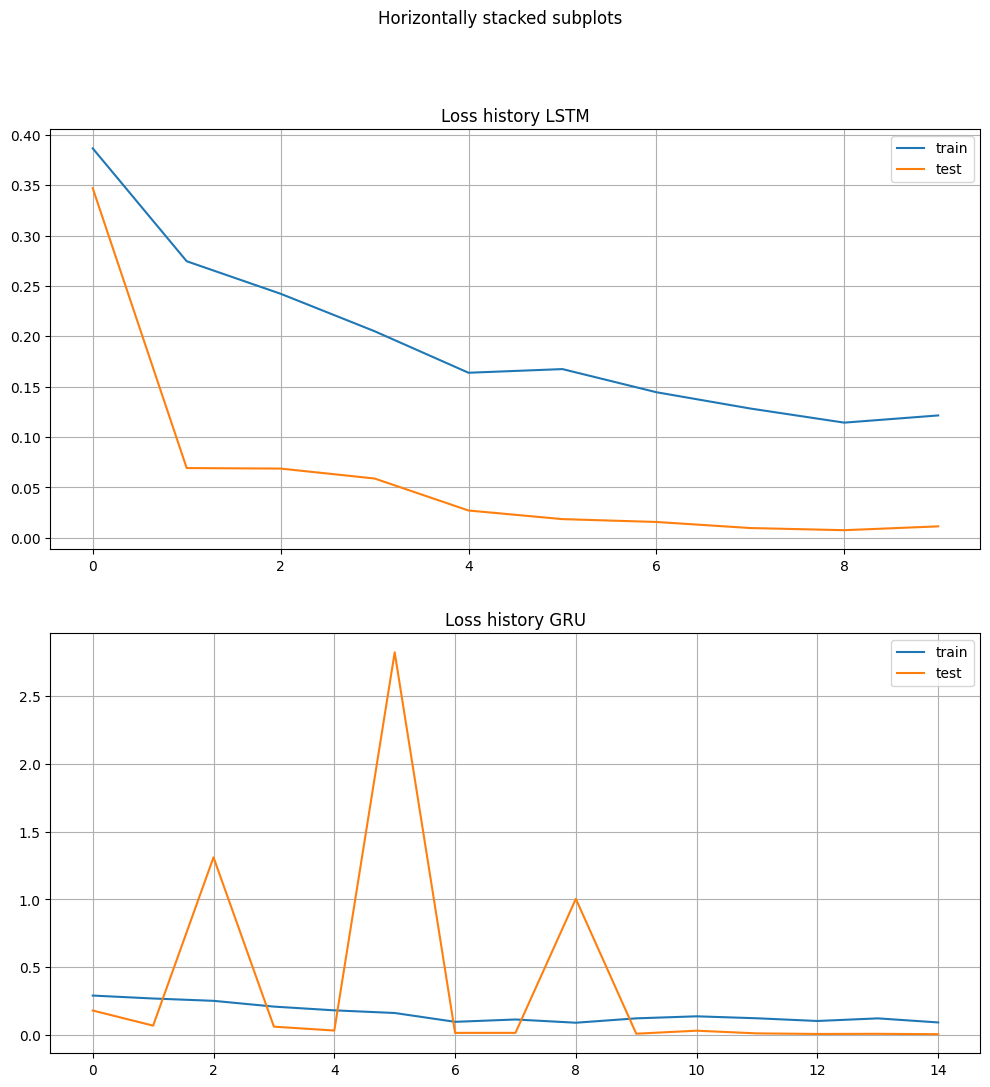

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Horizontally stacked subplots')
ax1.set_title('Loss history LSTM')
ax1.grid(True)
ax1.plot(train_loss_history_LSTM, label='train')
ax1.plot(test_loss_history_LSTM, label='test')
ax1.legend()

ax2.set_title('Loss history GRU')
ax2.grid(True)
ax2.plot(train_loss_history_GRU, label='train')
ax2.plot(test_loss_history_GRU, label='test')
ax2.legend()
plt.show()

In [45]:
print(f'Test loss LSTM: {t_l_LSTM:.3f}, Test acc LSTM: {t_acc_LSTM:.3f}')
print(f'Test loss GRU: {t_l_GRU:.3f}, Test acc GRU: {t_acc_GRU:.3f}')

Test loss LSTM: 0.011, Test acc LSTM: 0.948
Test loss GRU: 0.006, Test acc GRU: 0.952


**Вывод:** 

Результаты самописной сверточной сети для текстов из задания прошлого урока: 

Loss: 0.011. Acc: 0.997. Test loss: 0.000. Test acc: 0.944


||Test Loss|Test Acc|
|-|-|-|
|**LSTM**|0.011|0.948|
|**GRU**|0.006|0.952|
|**Самописная**|0.000|0.944|

Увеличение количество эпох с 5 до 10 в LSTM и с 5 до 15 в GRU оказалось избыточным, как в задании предыдущего урока. Потери сети LSTM вышли на плато на 8 эпохе, а потери GRU сделали это на 9 эпохе. При этом на графиках потерь мы видим, что потери GRU похожи на пики и довольно неровные, что на фоне LSTM выглядят хуже.

Значения метрики *Accuracy* на тестовой выборке не сильно разняться. Лучшим оказалась модель  GRU. Если сравнить результаты с самописной сеткой из задания предыдущего урока, то на тестовых данных модели LSTM и GRU ее превзошли, но незначительно. 

---